# Imports

In [ ]:
#Check if colab is running
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  %tensorflow_version 2.x
    
#import TF  
import tensorflow as tf
from platform import python_version
print("Tensorflow version", tf.__version__)
print("Python version =",python_version())

Tensorflow version 2.8.2
Python version = 3.7.13


In [ ]:
#test if gpu is running
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# all imports for the notebook
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.cm as cm
import itertools
import pandas as pd
import zipfile
import os
import seaborn as sns
from PIL import Image
import random as rnd
from tqdm import tqdm
from PIL import ImageFile
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import gc 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from tensorflow import keras


In [ ]:
################################################################################################### 


%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
###################################################################################################    


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
################################################################################################### 

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]), interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
################################################################################################### 


def evaluate(X_test, Y_test):
    
    ##Evaluate loss and metrics
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    # Predict the values from the test dataset
    Y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    Y_cls = np.argmax(Y_pred, axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(Y_test, axis = 1) 
    print('Classification Report:\n', classification_report(Y_true,Y_cls))
    
    ## Plot 0 probability
    label=0
    Y_pred_prob = Y_pred[:,label]
    plt.hist(Y_pred_prob[Y_true == label], alpha=0.5, color='red', bins=4, log = True)
    plt.hist(Y_pred_prob[Y_true != label], alpha=0.5, color='blue', bins=4, log = True)
    plt.legend(['target == 0', 'target != 0'], loc='upper right')
    plt.xlabel('Probability of being 0')
    plt.ylabel('Number of entries')
    plt.show()
    
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_cls) 
    # plot the confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(confusion_mtx, classes = range(4))

    #Plot largest errors
    errors = (Y_cls - Y_true != 0)
    Y_cls_errors = Y_cls[errors]
    Y_pred_errors = Y_pred[errors]
    Y_true_errors = Y_true[errors]
    X_test_errors = X_test[errors]
    # Probabilities of the wrong predicted numbers
    Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
    # Predicted probabilities of the true values in the error set
    true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    # Sorted list of the delta prob errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    # Top 6 errors 
    most_important_errors = sorted_dela_errors[-6:]
    # Show the top 6 errors
    display_errors(most_important_errors, X_test_errors, Y_cls_errors, Y_true_errors)
    
    ##Plot predictions
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)
    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test[i], interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
                 bbox=dict(facecolor='white', alpha=1))
        plt.text(16, 8,Y_true[i], color='black', 
                 bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

# Load Data

In [ ]:
#mount drive to notebook
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip dataset

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/grape_disease.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
main_path = '/tmp/grape_disease/'
path_Black_rot = main_path + 'Black_rot'
path_Esca = main_path + 'Esca'
path_Healthy = main_path + 'Healthy'
path_Leaf_blight = main_path + 'Leaf_blight'


In [ ]:

df = pd.DataFrame()
df['images'] = os.listdir(path_Black_rot) + os.listdir(path_Esca) + os.listdir(path_Healthy) + os.listdir(path_Leaf_blight)


In [ ]:
path_Healthy

'/tmp/grape_disease/Healthy'

In [ ]:
classes = []
paths = []
for image in df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)

df['classes'] = classes
df['path'] = paths
df.head()    

,images,classes,path
0,Black_rot (717).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (717).JPG
1,Black_rot (847).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (847).JPG
2,Black_rot (1015).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (1015).JPG
3,Black_rot (126).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (126).JPG
4,Black_rot (1073).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (1073).JPG


In [ ]:
print('Classes: ',len(df['classes'].value_counts()))
df['classes'].value_counts()

Classes:  4


Esca           1383
Black_rot      1180
Leaf_blight    1076
Healthy        1000
Name: classes, dtype: int64

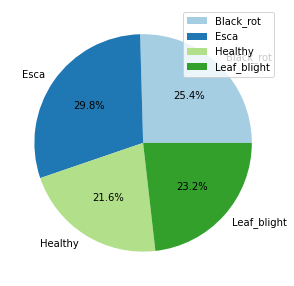

In [ ]:

plt.figure(figsize=(5,5))
class_cnt = df.groupby(['classes']).size().reset_index(name = 'counts')
colors = sns.color_palette('Paired')[0:9]
plt.pie(class_cnt['counts'], labels=class_cnt['classes'], colors=colors, autopct='%1.1f%%')
plt.legend(loc='upper right')
plt.show()

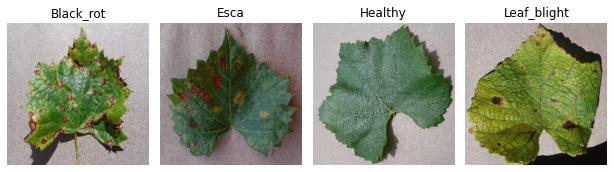

In [ ]:

plt.figure(figsize = (15,12))
for idx,i in enumerate(df.classes.unique()):
    plt.subplot(4,7,idx+1)
    df_image = df[df['classes'] ==i].reset_index(drop = True)
    image_path = df_image.loc[rnd.randint(0, len(df_image))-1,'path']
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:

widths, heights = [], []

for path in tqdm(df["path"]):
    width, height = Image.open(path).size
    widths.append(width)
    heights.append(height)
    
df["width"] = widths
df["height"] = heights
df["dimension"] = df["width"] * df["height"]

100%|██████████| 4639/4639 [00:00<00:00, 13774.17it/s]


In [ ]:
df.sort_values('width').head(84)

,images,classes,path,width,height,dimension
3478,Healthy (942).JPG,Healthy,/tmp/grape_disease/Healthy/Healthy (942).JPG,204,204,41616
3014,Healthy (832).JPG,Healthy,/tmp/grape_disease/Healthy/Healthy (832).JPG,204,204,41616
3015,Healthy (949).JPG,Healthy,/tmp/grape_disease/Healthy/Healthy (949).JPG,204,204,41616
3020,Healthy (648).JPG,Healthy,/tmp/grape_disease/Healthy/Healthy (648).JPG,204,204,41616
3023,Healthy (675).JPG,Healthy,/tmp/grape_disease/Healthy/Healthy (675).JPG,204,204,41616
...,...,...,...,...,...,...
3150,Healthy (552).JPG,Healthy,/tmp/grape_disease/Healthy/Healthy (552).JPG,204,204,41616
3154,Healthy (676).JPG,Healthy,/tmp/grape_disease/Healthy/Healthy (676).JPG,204,204,41616
3134,Healthy (501).JPG,Healthy,/tmp/grape_disease/Healthy/Healthy (501).JPG,204,204,41616
3115,Healthy (986).JPG,Healthy,/tmp/grape_disease/Healthy/Healthy (986).JPG,204,204,41616


In [ ]:
df.sort_values('width').tail(84)

,images,classes,path,width,height,dimension
1477,Esca (1180).JPG,Esca,/tmp/grape_disease/Esca/Esca (1180).JPG,256,256,65536
1467,Esca (1241).JPG,Esca,/tmp/grape_disease/Esca/Esca (1241).JPG,256,256,65536
1476,Esca (17).JPG,Esca,/tmp/grape_disease/Esca/Esca (17).JPG,256,256,65536
1474,Esca (1147).JPG,Esca,/tmp/grape_disease/Esca/Esca (1147).JPG,256,256,65536
1473,Esca (815).JPG,Esca,/tmp/grape_disease/Esca/Esca (815).JPG,256,256,65536
...,...,...,...,...,...,...
1543,Esca (664).JPG,Esca,/tmp/grape_disease/Esca/Esca (664).JPG,256,256,65536
1542,Esca (537).JPG,Esca,/tmp/grape_disease/Esca/Esca (537).JPG,256,256,65536
1541,Esca (1309).JPG,Esca,/tmp/grape_disease/Esca/Esca (1309).JPG,256,256,65536
1593,Esca (83).JPG,Esca,/tmp/grape_disease/Esca/Esca (83).JPG,256,256,65536


## Checking Colour distribution as alternative method to ML

In [ ]:
def get_rgb_men(row):
    img = cv2.imread(row['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return np.sum(img[:,:,0]), np.sum(img[:,:,1]), np.sum(img[:,:,2])

tqdm.pandas()
df['R'], df['G'], df['B'] = zip(*df.progress_apply(lambda row: get_rgb_men(row), axis=1))

100%|██████████| 4639/4639 [00:06<00:00, 743.69it/s]


In [ ]:
df['R'] = df['R']/df['dimension']
df['G'] = df['G']/df['dimension']
df['B'] = df['B']/df['dimension']


In [ ]:
df_color = df.groupby(['classes']).mean()

In [ ]:
df_color

,width,height,dimension,R,G,B
classes,,,,,,
Black_rot,256.000,256.000,65536.00,114.452181,121.961286,99.619764
Esca,256.000,256.000,65536.00,121.350440,126.311814,107.142322
Healthy,225.996,225.996,51734.16,119.310933,138.269566,106.884227
Leaf_blight,256.000,256.000,65536.00,127.306332,130.798184,92.545365


just from the mean of the color channels it should be possible to classify the images

In [ ]:
one_hot_true, prediction = [],[]

classes = df['classes'].to_list()

for element in classes:
  if element =="Black_rot":
    element = 0
  elif element == "Esca":
    element = 1
  elif element == "Healthy":
    element = 2
  else:
    element = 3
  one_hot_true.append(element)          

df['classes_one_hot'] = one_hot_true

df.head()

,images,classes,path,width,height,dimension,R,G,B,classes_one_hot
0,Black_rot (717).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (717).JPG,256,256,65536,106.015106,113.103790,100.016266,0
1,Black_rot (847).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (847).JPG,256,256,65536,116.086777,126.863571,105.467636,0
2,Black_rot (1015).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (1015).JPG,256,256,65536,120.635574,126.145447,107.129150,0
3,Black_rot (126).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (126).JPG,256,256,65536,116.956589,125.272827,106.797760,0
4,Black_rot (1073).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (1073).JPG,256,256,65536,138.540848,151.587936,123.945206,0


In [ ]:
green_values = df['G'].to_list()
for element in green_values:
  if element < 126:
    pred = 0
  elif element > 126 and element < 130:
    pred = 1
  elif element > 130 and  element < 138:
    pred = 3
  else:
    pred = 2  
  prediction.append(pred)

df['prediction'] = prediction

df.head()

,images,classes,path,width,height,dimension,R,G,B,classes_one_hot,prediction
0,Black_rot (717).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (717).JPG,256,256,65536,106.015106,113.103790,100.016266,0,0
1,Black_rot (847).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (847).JPG,256,256,65536,116.086777,126.863571,105.467636,0,1
2,Black_rot (1015).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (1015).JPG,256,256,65536,120.635574,126.145447,107.129150,0,1
3,Black_rot (126).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (126).JPG,256,256,65536,116.956589,125.272827,106.797760,0,0
4,Black_rot (1073).JPG,Black_rot,/tmp/grape_disease/Black_rot/Black_rot (1073).JPG,256,256,65536,138.540848,151.587936,123.945206,0,2


Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.63      0.47      1180
           1       0.42      0.20      0.27      1383
           2       0.48      0.47      0.47      1000
           3       0.23      0.22      0.23      1076

    accuracy                           0.37      4639
   macro avg       0.38      0.38      0.36      4639
weighted avg       0.38      0.37      0.36      4639



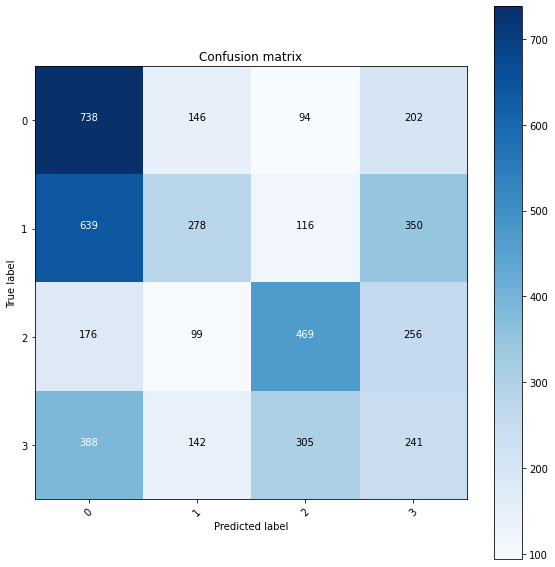

In [ ]:
Y_true = df['classes_one_hot']
Y_cls = df['prediction']
print('Classification Report:\n', classification_report(Y_true,Y_cls))
confusion_mtx = confusion_matrix(Y_true, Y_cls) 
# plot the confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_mtx, classes = range(4))


## Prepare Images for training

In [ ]:


IMAGE_WIDTH = 204 #204 #128
IMAGE_HEIGHT = 204 #204 #128
IMAGE_CHANNELS = 3

img_data=[]
class_name=[]
    
for i in range(len(df)) :
       
  image_path= df["path"][i]
  image= cv2.imread( image_path, cv2.COLOR_BGR2RGB) # images keep their shape
  image=cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH),interpolation = cv2.INTER_AREA)
  #image= np.array(Image.open(image_path)) #pictures get smeared put after normilization with pillow
  #image= np.resize(image,(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS))
  image=np.array(image)
  image = image.astype('float32')
  img_data.append(image)
  class_name.append(df['classes'][i])

In [ ]:
img_data = np.array(img_data)
img_data.shape

(4639, 204, 204, 3)

In [ ]:
img_data[0]

array([[[134., 133., 143.],
        [102., 101., 111.],
        [124., 123., 133.],
        ...,
        [148., 148., 160.],
        [142., 142., 154.],
        [132., 132., 144.]],

       [[118., 117., 127.],
        [113., 112., 122.],
        [114., 113., 123.],
        ...,
        [143., 143., 155.],
        [149., 149., 161.],
        [144., 144., 156.]],

       [[128., 127., 137.],
        [124., 123., 133.],
        [138., 137., 147.],
        ...,
        [133., 133., 145.],
        [147., 147., 159.],
        [146., 146., 158.]],

       ...,

       [[202., 199., 201.],
        [208., 205., 207.],
        [200., 197., 199.],
        ...,
        [178., 178., 184.],
        [176., 176., 182.],
        [171., 171., 177.]],

       [[203., 200., 202.],
        [206., 203., 205.],
        [205., 202., 204.],
        ...,
        [178., 178., 184.],
        [178., 178., 184.],
        [170., 170., 176.]],

       [[204., 201., 203.],
        [201., 198., 200.],
        [204., 2

In [ ]:
img_data/= 255.0

#scaler = MinMaxScaler(feature_range=(0, 1))
#reshape each channel
#channel_1= img_data[:,:,:,0].reshape(img_data.shape[0],-1)
#channel_2= img_data[:,:,:,0].reshape(img_data.shape[1],-1)
#channel_3= img_data[:,:,:,0].reshape(img_data.shape[2],-1)
#normalize each channel
#channel_1 = scaler.fit_transform(channel_1)
#channel_2 = scaler.fit_transform(channel_2)
#channel_3 = scaler.fit_transform(channel_3)
#noramlized channels to img_data
#img_data[:,:,:,0] = channel_1.reshape(img_data.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT)
#img_data[:,:,:,1] = channel_2.reshape(img_data.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT)
#img_data[:,:,:,2] = channel_3.reshape(img_data.shape[0],IMAGE_WIDTH,IMAGE_HEIGHT)

In [ ]:
img_data.shape

(4639, 204, 204, 3)

In [ ]:
#preparing target
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
print(target_dict)
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]
print(target_val)


{'Black_rot': 0, 'Esca': 1, 'Healthy': 2, 'Leaf_blight': 3}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
#create categorical target
img_class_categorical= to_categorical(target_val,4)

In [ ]:

#train test split
X_train, X_test, Y_train, Y_test = train_test_split(img_data, img_class_categorical, test_size=0.2, random_state=42, stratify=img_class_categorical)
#test val split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42, stratify=Y_train)

In [ ]:
Y_val.shape

(1114, 4)

In [ ]:
#clearing some meomory 


del df
del img_data
del img_class_categorical
del class_name
del target_val
del target_dict
#del channel_1
#del channel_2
#del channel_3
del classes
del paths
del widths
del heights

gc.collect()

11145

# Testing different Model architectures

In [ ]:
# -- Initializing the values for the convolution neural network

nb_epoch = 50  # kept very low! Please increase if you can use a GPU

batch_size = 128
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

## Standard architecture from Excercise

In [ ]:


model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu', 
                 input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
model.add(Conv2D(64, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
          
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 202, 202, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 640000)            0         
                                                                 
 dense (Dense)               (None, 128)               81920128  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                        

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_val, Y_val))

Epoch 1/50
21/21 [==============================] - 19s 522ms/step - loss: 9.3283 - accuracy: 0.2819 - val_loss: 1.2853 - val_accuracy: 0.4488
Epoch 2/50
21/21 [==============================] - 8s 371ms/step - loss: 0.9186 - accuracy: 0.5864 - val_loss: 0.6201 - val_accuracy: 0.7011
Epoch 3/50
21/21 [==============================] - 8s 367ms/step - loss: 0.4380 - accuracy: 0.8021 - val_loss: 0.4317 - val_accuracy: 0.8259
Epoch 4/50
21/21 [==============================] - 8s 372ms/step - loss: 0.2550 - accuracy: 0.9068 - val_loss: 0.2547 - val_accuracy: 0.9057
Epoch 5/50
21/21 [==============================] - 8s 375ms/step - loss: 0.1591 - accuracy: 0.9511 - val_loss: 0.2059 - val_accuracy: 0.9156
Epoch 6/50
21/21 [==============================] - 8s 376ms/step - loss: 0.0745 - accuracy: 0.9773 - val_loss: 0.1957 - val_accuracy: 0.9255
Epoch 7/50
21/21 [==============================] - 8s 381ms/step - loss: 0.0472 - accuracy: 0.9881 - val_loss: 0.2452 - val_accuracy: 0.9102
Epoch

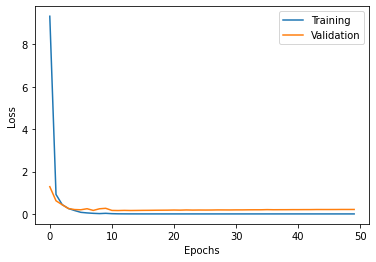

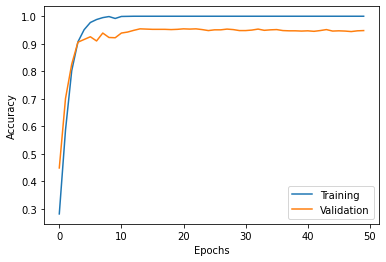

In [ ]:
plot_history(hist)

Test Loss: 0.21799734234809875
Test Accuracy: 0.951508641242981
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       236
           1       0.94      0.91      0.93       277
           2       0.99      0.99      0.99       200
           3       1.00      0.98      0.99       215

    accuracy                           0.95       928
   macro avg       0.96      0.96      0.96       928
weighted avg       0.95      0.95      0.95       928



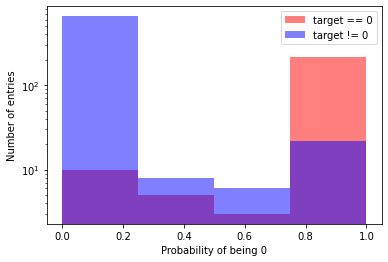

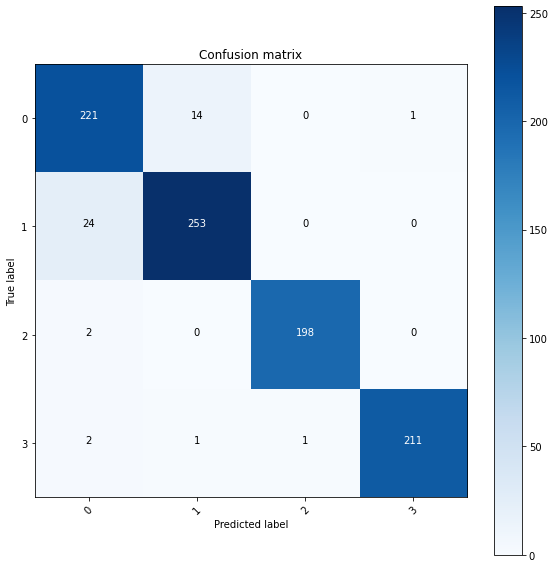

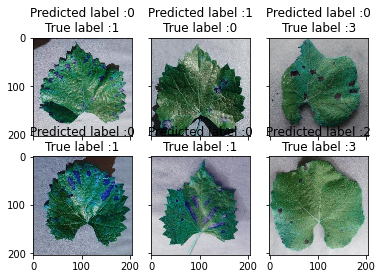

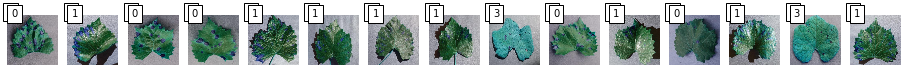

In [ ]:
evaluate(X_test, Y_test)

In [ ]:
del hist

gc.collect()

42833

## AlexNet

In [ ]:
#Testing alexnet
model = Sequential()

model.add(Conv2D(filters=96, kernel_size=11, strides=4, activation='relu', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))
model.add(Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))
model.add(Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))
model.add(Flatten())
model.add(Dense(4096, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
          
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 49, 49, 96)        34944     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 256)       614656    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 384)       885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 384)      

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=50, verbose=1, 
                 validation_data=(X_val, Y_val))

Epoch 1/50
21/21 [==============================] - 7s 221ms/step - loss: 1.6440 - accuracy: 0.2534 - val_loss: 1.3851 - val_accuracy: 0.2540
Epoch 2/50
21/21 [==============================] - 3s 136ms/step - loss: 1.3774 - accuracy: 0.2838 - val_loss: 1.3598 - val_accuracy: 0.2980
Epoch 3/50
21/21 [==============================] - 3s 146ms/step - loss: 1.3443 - accuracy: 0.3369 - val_loss: 1.2463 - val_accuracy: 0.4623
Epoch 4/50
21/21 [==============================] - 3s 136ms/step - loss: 1.1342 - accuracy: 0.4621 - val_loss: 0.9830 - val_accuracy: 0.5628
Epoch 5/50
21/21 [==============================] - 3s 137ms/step - loss: 0.9543 - accuracy: 0.5614 - val_loss: 0.8407 - val_accuracy: 0.6194
Epoch 6/50
21/21 [==============================] - 3s 137ms/step - loss: 0.8594 - accuracy: 0.6138 - val_loss: 0.8244 - val_accuracy: 0.6284
Epoch 7/50
21/21 [==============================] - 3s 138ms/step - loss: 0.7722 - accuracy: 0.6450 - val_loss: 0.7395 - val_accuracy: 0.6364
Epoch 

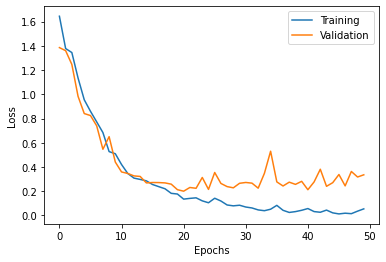

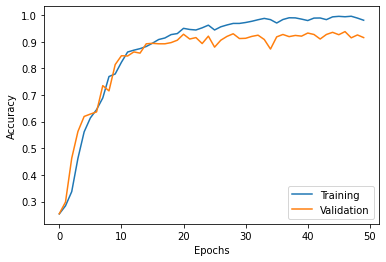

In [ ]:
plot_history(hist)

Test Loss: 0.3377173840999603
Test Accuracy: 0.912715494632721
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85       236
           1       0.87      0.95      0.91       277
           2       0.95      0.99      0.97       200
           3       0.99      0.89      0.94       215

    accuracy                           0.91       928
   macro avg       0.92      0.91      0.92       928
weighted avg       0.91      0.91      0.91       928



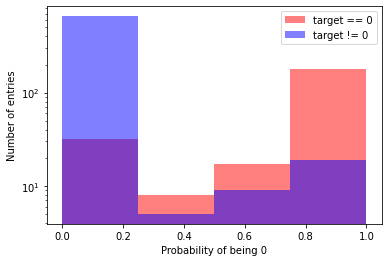

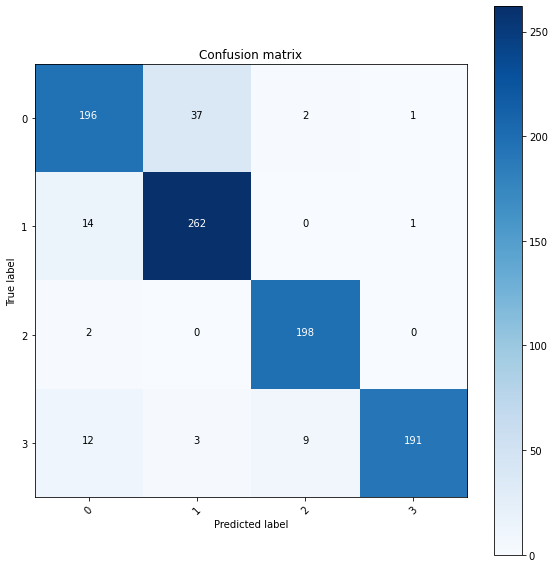

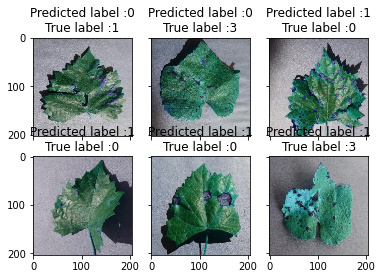

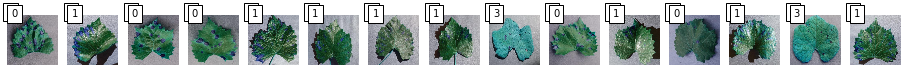

In [ ]:
evaluate(X_test, Y_test)

In [ ]:
del hist

gc.collect()

57719

## Adding more Convolution and Pooling to standard Model 

In [ ]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu', 
                 input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
model.add(Conv2D(128, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
model.add(Conv2D(32, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
          
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 202, 202, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 200, 200, 128)     36992     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 128)    0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 98, 98, 64)        73792     
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                  

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=30, verbose=1, 
                 validation_data=(X_val, Y_val))

Epoch 1/30
21/21 [==============================] - 29s 1s/step - loss: 1.4251 - accuracy: 0.2715 - val_loss: 1.3702 - val_accuracy: 0.2980
Epoch 2/30
21/21 [==============================] - 16s 762ms/step - loss: 1.3540 - accuracy: 0.2938 - val_loss: 1.3144 - val_accuracy: 0.3151
Epoch 3/30
21/21 [==============================] - 16s 749ms/step - loss: 1.2660 - accuracy: 0.3492 - val_loss: 1.2013 - val_accuracy: 0.5485
Epoch 4/30
21/21 [==============================] - 15s 740ms/step - loss: 1.1794 - accuracy: 0.4578 - val_loss: 1.1147 - val_accuracy: 0.6212
Epoch 5/30
21/21 [==============================] - 15s 741ms/step - loss: 1.0872 - accuracy: 0.5052 - val_loss: 0.9092 - val_accuracy: 0.5934
Epoch 6/30
21/21 [==============================] - 16s 750ms/step - loss: 0.9052 - accuracy: 0.5872 - val_loss: 0.6329 - val_accuracy: 0.7172
Epoch 7/30
21/21 [==============================] - 16s 753ms/step - loss: 0.8855 - accuracy: 0.5984 - val_loss: 0.7081 - val_accuracy: 0.7154
Ep

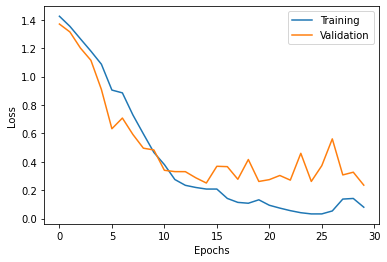

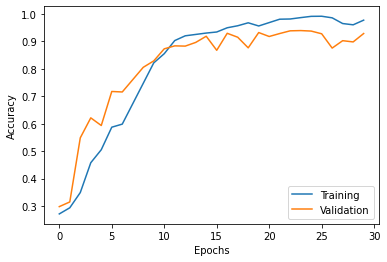

In [ ]:
plot_history(hist)

Test Loss: 0.25396546721458435
Test Accuracy: 0.9299569129943848
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87       236
           1       0.87      0.98      0.92       277
           2       0.98      0.98      0.98       200
           3       0.95      0.95      0.95       215

    accuracy                           0.93       928
   macro avg       0.94      0.93      0.93       928
weighted avg       0.93      0.93      0.93       928



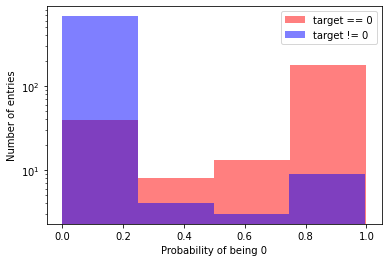

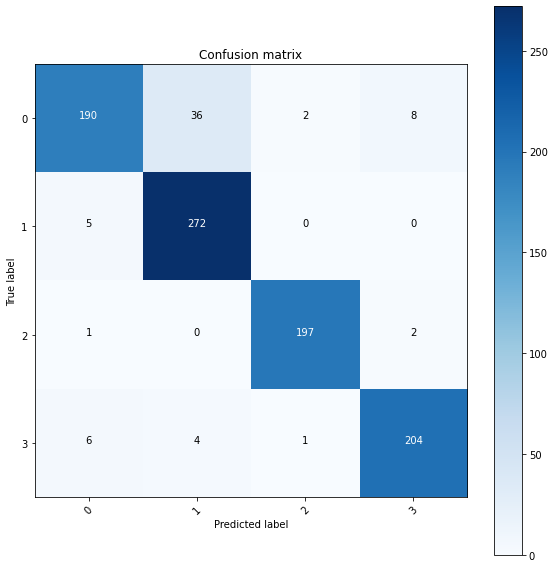

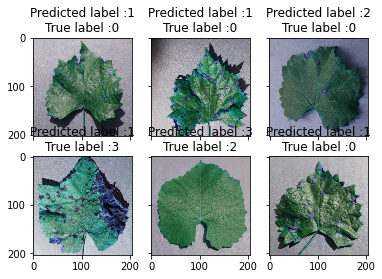

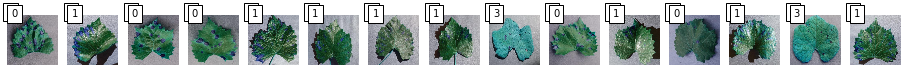

In [ ]:
evaluate(X_test, Y_test)

## VGG16

In [ ]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
#from tensorflow.keras.optimizers import Adam, SGD
#model = Sequential()
#model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#model.add(Flatten())
#model.add(Dense(units=4096,activation="relu")) # maybe to many neurons
#model.add(Dropout(0.5))
#model.add(Dense(units=406,activation="relu"))
#model.add(Dense(units=16,activation="sigmoid"))
#model.add(Dropout(0.5))
#model.add(Dense(units=4, activation="softmax"))

#model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])
# SGD optimizier is probably better suited
#opt = Adam(
#    learning_rate=0.01)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()
# add dropout layers + regularization

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

#early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
#hist = model.fit(X_train, Y_train, batch_size=64, 
#                 epochs=50, verbose=1, 
#                 validation_data=(X_val, Y_val))
#                 callbacks=[early])

# Hyperparameter Optimization

In [ ]:
#take a smaller dataset for the optimization 
stratSplit = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state= 42)
print('Train')
for train_index, test_index in stratSplit.split(X_train, Y_train):
  x_train = X_train[train_index]
  y_train = Y_train[train_index]
  print(x_train.shape)
  print(y_train.shape)
print('Val')
for train_index, test_index in stratSplit.split(X_val, Y_val):  
  x_val = X_val[train_index]
  y_val = Y_val[train_index]
  print(x_val.shape)
  print(y_val.shape)
print('Test')
for train_index, test_index in stratSplit.split(X_test, Y_test):
  x_test = X_test[train_index]
  y_test = Y_test[train_index]
  print(x_test.shape)
  print(y_test.shape)
  
#x_train = X_train[:400]
#y_train = Y_train[:400]
#x_val = X_val[:100]
#y_val = Y_val[:100]
#x_test = X_test[:100]
#y_test = Y_test[:100]

Train
(519, 128, 128, 3)
(519, 4)
Val
(222, 128, 128, 3)
(222, 4)
Test
(185, 128, 128, 3)
(185, 4)


## Testing different evaluation metrics

In [ ]:

search_results = []

eval_metric_candidates = [
  # very limited test, you can explore more!
  'accuracy', 'hinge', 'poisson','logcosh','cosine_similarity'
]

for eval_metric in eval_metric_candidates:
  print("Start training for eval meteric=", eval_metric)

  ########################################
  # Use your own model here!!
  ########################################
  model = Sequential()

  model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu', 
                 input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
  model.add(Conv2D(128, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
  model.add(Conv2D(32, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
          
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[eval_metric])
  
  ########################################
    # we choose our best model as the one having the highest validation accuracy
  filepath = f"cnn_paramsearch_filters_{eval_metric}.hdf5"
  checkpoint = ModelCheckpoint(
      filepath, monitor='val_'+ eval_metric , verbose=0, save_best_only=True, mode='max'
  )
  
  fit_results = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=64,
    # reduce number of epochs for speed reasons --> should be higher!
    epochs=10, 
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
    verbose=0
  )

  # extract the best validation scores
  best_val_epoch    = np.argmax(fit_results.history['val_'+ eval_metric])
  best_val_acc      = np.max(fit_results.history['val_'+ eval_metric])
  best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

  # get confusion matrix

  best_model = load_model(filepath)
  # Predict the values from the test dataset
  y_pred = best_model.predict(x_test)
  # Convert predictions classes to one hot vectors 
  y_cls = np.argmax(y_pred, axis = 1) 
  # Convert validation observations to one hot vectors
  y_true = np.argmax(y_test, axis = 1) 

  conf_mat = confusion_matrix(y_true, y_cls)

  # store results
  search_results.append({
      'eval_metric': eval_metric,
      'confusion_matrix': conf_mat
  })

Start training for eval meteric= accuracy
Start training for eval meteric= hinge
Start training for eval meteric= poisson
Start training for eval meteric= logcosh
Start training for eval meteric= cosine_similarity


In [ ]:
search_results

[{'confusion_matrix': array([[ 0, 24,  0,  1],
         [ 0, 34,  0,  0],
         [ 0, 14,  0,  1],
         [ 1, 18,  0,  7]]), 'eval_metric': 'accuracy'},
 {'confusion_matrix': array([[ 0, 23,  0,  2],
         [ 0, 27,  0,  7],
         [ 0, 13,  0,  2],
         [ 0,  7,  0, 19]]), 'eval_metric': 'hinge'},
 {'confusion_matrix': array([[ 0, 25,  0,  0],
         [ 0, 34,  0,  0],
         [ 0, 15,  0,  0],
         [ 0, 26,  0,  0]]), 'eval_metric': 'poisson'},
 {'confusion_matrix': array([[ 0, 25,  0,  0],
         [ 0, 34,  0,  0],
         [ 0, 15,  0,  0],
         [ 0, 26,  0,  0]]), 'eval_metric': 'logcosh'},
 {'confusion_matrix': array([[ 1,  8, 16,  0],
         [ 1, 25,  8,  0],
         [ 0,  0, 15,  0],
         [ 0,  5,  4, 17]]), 'eval_metric': 'cosine_similarity'}]

Cosine similarity seems to work best on the small subset. Now test it on the big data set to give a fair comparison to accuracy.

In [ ]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu', 
                 input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)))
model.add(Conv2D(128, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
model.add(Conv2D(32, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
          
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['cosine_similarity'])

hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=30, verbose=1, 
                 validation_data=(X_val, Y_val))

Epoch 1/30
21/21 [==============================] - 42s 1s/step - loss: 1.4248 - cosine_similarity: 0.4973 - val_loss: 1.3709 - val_cosine_similarity: 0.5078
Epoch 2/30
21/21 [==============================] - 16s 788ms/step - loss: 1.3063 - cosine_similarity: 0.5345 - val_loss: 1.1913 - val_cosine_similarity: 0.5912
Epoch 3/30
21/21 [==============================] - 16s 781ms/step - loss: 1.0716 - cosine_similarity: 0.6248 - val_loss: 0.8766 - val_cosine_similarity: 0.6932
Epoch 4/30
21/21 [==============================] - 16s 782ms/step - loss: 0.9030 - cosine_similarity: 0.6923 - val_loss: 0.8445 - val_cosine_similarity: 0.7329
Epoch 5/30
21/21 [==============================] - 16s 788ms/step - loss: 0.8489 - cosine_similarity: 0.7234 - val_loss: 0.6081 - val_cosine_similarity: 0.8129
Epoch 6/30
21/21 [==============================] - 16s 789ms/step - loss: 0.6432 - cosine_similarity: 0.8016 - val_loss: 0.4386 - val_cosine_similarity: 0.8657
Epoch 7/30
21/21 [===================

Test Loss: 0.29365548491477966
Test Accuracy: 0.944441020488739
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       236
           1       0.90      0.95      0.93       277
           2       0.99      0.97      0.98       200
           3       0.98      0.94      0.96       215

    accuracy                           0.94       928
   macro avg       0.94      0.94      0.94       928
weighted avg       0.94      0.94      0.94       928



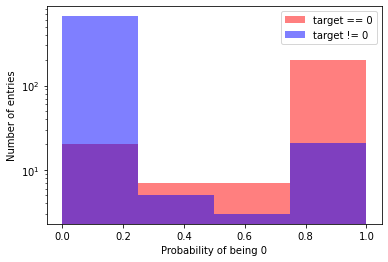

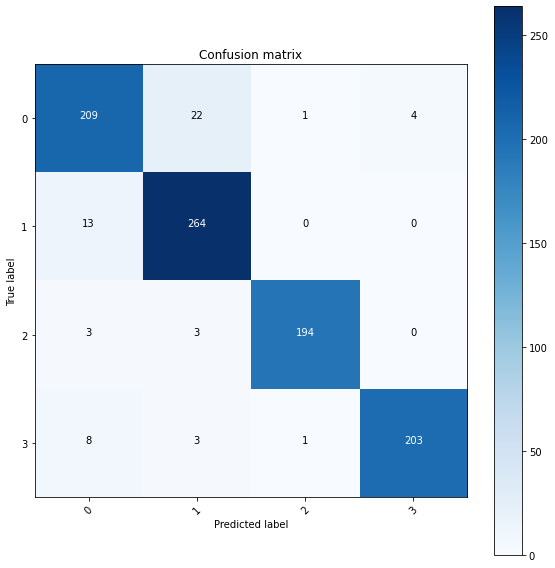

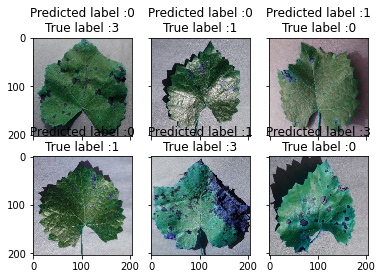

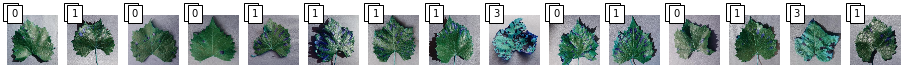

In [ ]:
evaluate(X_test, Y_test)

## Testing different model structures

In [ ]:
#eval metric best suited seems to be cosine_similarity
param_space = {
    'num_conv_layers': [3,4,5],
    'max_filters': [32, 64,128],
    'dropout': [.3,.5, .6],
    'dense_nodes': [32, 64, 128]
}

# this handy tools generates all combinations of values from the grid above
import itertools
value_combis = itertools.product(*[v for v in param_space.values()])

param_combis = []
for combi in value_combis:
  param_combis.append({key: value for key, value in zip(param_space.keys(), combi)})

# List comprehension short form:
# param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

We have a total of 81 combinations:
[{'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 32}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 128}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 32}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 128}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.6, 'dense_nodes': 32}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.6, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.6, 'dense_nodes': 128}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': 32}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': 128}, {'num_conv_layers': 3, 

In [ ]:
from tensorflow.keras.callbacks import Callback

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data       

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_cosine_similarity'] = a


In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
  
    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")


    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid', 
          activation='relu'
      ))
      filters /= 2
    
    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
      Dense(params['dense_nodes'], activation='relu'),
      Dropout(params['dropout']),
      Dense(4, activation='softmax')    
    ]:
      model.add(layer)

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['cosine_similarity']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_cosine_similarity', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train, 
      y=y_train, 
      batch_size=64,
      # reduce number of epochs for speed reasons --> should be higher!
      epochs=10, 
      validation_data=(x_val, y_val), 
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_cosine_similarity'])
    best_val_cos      = np.max(fit_results.history['val_cosine_similarity'])
    best_val_cos_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_model = load_model(filepath)
    best_val_cos_train_loss, best_val_cos_train_cos = best_model.evaluate(x_train, y_train)

    # store results
    search_results.append({
        **params,
        'best_val_cos_train_cos': best_val_cos_train_cos,
        'best_val_cos': best_val_cos,
        'best_val_cos_train_loss': best_val_cos_train_loss,
        'best_val_cos_loss': best_val_cos_loss,
        'best_val_epoch': best_val_epoch,
         'history': fit_results.history
    })

Start run 1/81: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 32}
13/13 [==============================] - 0s 9ms/step - loss: 0.7463 - cosine_similarity: 0.7481
Start run 2/81: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 64}
13/13 [==============================] - 0s 9ms/step - loss: 0.6685 - cosine_similarity: 0.7983
Start run 3/81: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 128}
13/13 [==============================] - 0s 9ms/step - loss: 0.2202 - cosine_similarity: 0.9474
Start run 4/81: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 32}
13/13 [==============================] - 0s 10ms/step - loss: 0.4376 - cosine_similarity: 0.8668
Start run 5/81: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.5, 'dense_nodes': 64}
13/13 [==============================] - 0s 9ms/step - loss: 0.3821 - cosine_similarity: 

In [ ]:
# which combinations perform best?
df = pd.DataFrame(search_results).sort_values('best_val_cos', ascending=False)
display(df)

,num_conv_layers,max_filters,dropout,dense_nodes,best_val_cos_train_cos,best_val_cos,best_val_cos_train_loss,best_val_cos_loss,best_val_epoch,history
16,3,64,0.6,64,0.963239,0.927771,0.168846,0.247498,9,"{'loss': [1.3704105615615845, 1.20705676078796..."
20,3,128,0.3,128,0.990154,0.927395,0.060106,0.220768,9,"{'loss': [2.5188231468200684, 1.35679781436920..."
23,3,128,0.5,128,0.982694,0.919531,0.077199,0.234282,9,"{'loss': [1.9147725105285645, 1.25522911548614..."
77,5,128,0.5,128,0.952115,0.913360,0.192504,0.270077,9,"{'loss': [1.3834619522094727, 1.15847015380859..."
10,3,64,0.3,64,0.957082,0.906850,0.198252,0.317043,8,"{'loss': [1.429389238357544, 1.235078692436218..."
...,...,...,...,...,...,...,...,...,...,...
58,5,32,0.5,64,0.689688,0.671958,0.916192,0.953557,9,"{'loss': [1.3898468017578125, 1.36541140079498..."
12,3,64,0.5,32,0.674212,0.668878,0.972917,0.996908,9,"{'loss': [1.8477870225906372, 1.38535702228546..."
73,5,128,0.3,64,0.654672,0.615059,1.064513,1.134580,9,"{'loss': [1.4553414583206177, 1.38875627517700..."
62,5,32,0.6,128,0.614260,0.605097,1.121315,1.150634,9,"{'loss': [1.3972413539886475, 1.37378215789794..."


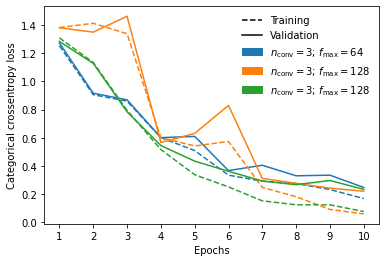

In [ ]:


top_3_indices = df.index.values[:3]

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"$n_\\mathrm{{conv}}=${row_series['num_conv_layers']}; $f_\\mathrm{{max}}=${row_series['max_filters']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
# limit ticks to integers using the length of the last results loss curve
plt.xticks(x)
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)

## Keeping best Nr. of conv. layers while varying other parameters

In [ ]:
#eval metric best suited seems to be cosine_similarity
param_space = {
    'num_conv_layers': [3],
    'max_filters': [32, 64,128,256],
    'dropout': [.2,.3,.4,.5],
    'dense_nodes': [16,32, 64, 128,256]
}

# this handy tools generates all combinations of values from the grid above
import itertools
value_combis = itertools.product(*[v for v in param_space.values()])

param_combis = []
for combi in value_combis:
  param_combis.append({key: value for key, value in zip(param_space.keys(), combi)})

# List comprehension short form:
# param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

We have a total of 80 combinations:
[{'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 16}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 32}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 128}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 256}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 16}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 32}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 128}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 256}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.4, 'dense_nodes': 16}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.4, 'dense_nodes': 32}, {'num_conv_layers': 3, 

In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
  
    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")


    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid', 
          activation='relu'
      ))
      filters /= 2
    
    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
      Dense(params['dense_nodes'], activation='relu'),
      Dropout(params['dropout']),
      Dense(4, activation='softmax')    
    ]:
      model.add(layer)

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['cosine_similarity']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_cosine_similarity', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train, 
      y=y_train, 
      batch_size=64,
      # reduce number of epochs for speed reasons --> should be higher!
      epochs=10, 
      validation_data=(x_val, y_val), 
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_cosine_similarity'])
    best_val_cos      = np.max(fit_results.history['val_cosine_similarity'])
    best_val_cos_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_model = load_model(filepath)
    best_val_cos_train_loss, best_val_cos_train_cos = best_model.evaluate(x_train, y_train)

    # store results
    search_results.append({
        **params,
        'best_val_cos_train_cos': best_val_cos_train_cos,
        'best_val_cos': best_val_cos,
        'best_val_cos_train_loss': best_val_cos_train_loss,
        'best_val_cos_loss': best_val_cos_loss,
        'best_val_epoch': best_val_epoch,
         'history': fit_results.history
    })

Start run 1/80: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 16}
17/17 [==============================] - 0s 9ms/step - loss: 0.8108 - cosine_similarity: 0.7373
Start run 2/80: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 32}
17/17 [==============================] - 0s 9ms/step - loss: 0.2147 - cosine_similarity: 0.9436
Start run 3/80: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 64}
17/17 [==============================] - 0s 11ms/step - loss: 0.3846 - cosine_similarity: 0.9008
Start run 4/80: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 128}
17/17 [==============================] - 1s 9ms/step - loss: 0.1504 - cosine_similarity: 0.9643
Start run 5/80: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.2, 'dense_nodes': 256}
17/17 [==============================] - 0s 11ms/step - loss: 0.0954 - cosine_similarity

,num_conv_layers,max_filters,dropout,dense_nodes,best_val_cos_train_cos,best_val_cos,best_val_cos_train_loss,best_val_cos_loss,best_val_epoch,history
27,3,64,0.3,64,0.989985,0.920255,0.065626,0.251471,9,"{'loss': [1.396228551864624, 1.085437178611755..."
49,3,128,0.3,256,0.970784,0.919076,0.138876,0.260956,7,"{'loss': [3.065706729888916, 1.196975231170654..."
48,3,128,0.3,128,0.991709,0.916931,0.056362,0.245651,9,"{'loss': [1.6534541845321655, 1.17338109016418..."
14,3,32,0.4,256,0.995995,0.913052,0.040648,0.263594,9,"{'loss': [1.3983895778656006, 0.93490356206893..."
73,3,256,0.4,128,0.969496,0.912115,0.118327,0.269496,9,"{'loss': [2.907946825027466, 1.295956254005432..."
...,...,...,...,...,...,...,...,...,...,...
45,3,128,0.3,16,0.549546,0.543294,1.278106,1.290847,9,"{'loss': [1.7247081995010376, 1.38684976100921..."
76,3,256,0.5,32,0.502967,0.502523,1.380478,1.381290,0,"{'loss': [1.745729923248291, 1.377849340438842..."
61,3,256,0.2,32,0.503063,0.502143,1.380173,1.382023,2,"{'loss': [1.8766670227050781, 1.38391673564910..."
30,3,64,0.4,16,0.501471,0.501403,1.383369,1.383504,9,"{'loss': [1.5488693714141846, 1.38611161708831..."


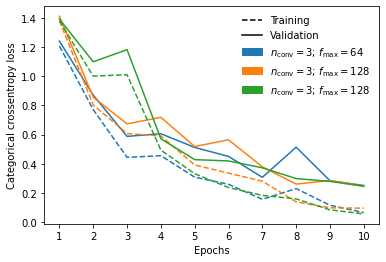

In [ ]:
df = pd.DataFrame(search_results).sort_values('best_val_cos', ascending=False)
display(df)



top_3_indices = df.index.values[:3]

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"$n_\\mathrm{{conv}}=${row_series['num_conv_layers']}; $f_\\mathrm{{max}}=${row_series['max_filters']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
# limit ticks to integers using the length of the last results loss curve
plt.xticks(x)
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)

## All best candidates had dropout of 0.3 

In [ ]:
## All best candidates had dropout of 0.3 
param_space = {
    'num_conv_layers': [3],
    'max_filters': [32, 64,128,256],
    'dropout': [.3],
    'dense_nodes': [16,32, 64, 128,256,512]
}

# this handy tools generates all combinations of values from the grid above
import itertools
value_combis = itertools.product(*[v for v in param_space.values()])

param_combis = []
for combi in value_combis:
  param_combis.append({key: value for key, value in zip(param_space.keys(), combi)})

# List comprehension short form:
# param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

We have a total of 24 combinations:
[{'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 16}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 32}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 128}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 256}, {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 512}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': 16}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': 32}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': 64}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': 128}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': 256}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': 512}, {'num_conv_layers': 3

In [ ]:
search_results = []

for idx, params in enumerate(param_combis):
  
    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")


    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid', 
          activation='relu'
      ))
      filters /= 2
    
    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
      Dense(params['dense_nodes'], activation='relu'),
      Dropout(params['dropout']),
      Dense(4, activation='softmax')    
    ]:
      model.add(layer)

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['cosine_similarity']
    )
    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_cosine_similarity', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train, 
      y=y_train, 
      batch_size=64,
      # reduce number of epochs for speed reasons --> should be higher!
      epochs=10, 
      validation_data=(x_val, y_val), 
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_cosine_similarity'])
    best_val_cos      = np.max(fit_results.history['val_cosine_similarity'])
    best_val_cos_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_model = load_model(filepath)
    best_val_cos_train_loss, best_val_cos_train_cos = best_model.evaluate(x_train, y_train)

    # store results
    search_results.append({
        **params,
        'best_val_cos_train_cos': best_val_cos_train_cos,
        'best_val_cos': best_val_cos,
        'best_val_cos_train_loss': best_val_cos_train_loss,
        'best_val_cos_loss': best_val_cos_loss,
        'best_val_epoch': best_val_epoch,
         'history': fit_results.history
    })

Start run 1/24: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 16}
17/17 [==============================] - 0s 9ms/step - loss: 0.8836 - cosine_similarity: 0.7032
Start run 2/24: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 32}
17/17 [==============================] - 0s 9ms/step - loss: 0.8162 - cosine_similarity: 0.7268
Start run 3/24: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 64}
17/17 [==============================] - 1s 14ms/step - loss: 0.5666 - cosine_similarity: 0.8169
Start run 4/24: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 128}
17/17 [==============================] - 0s 9ms/step - loss: 0.1922 - cosine_similarity: 0.9629
Start run 5/24: Parameters: {'num_conv_layers': 3, 'max_filters': 32, 'dropout': 0.3, 'dense_nodes': 256}
17/17 [==============================] - 0s 9ms/step - loss: 0.3984 - cosine_similarity:

,num_conv_layers,max_filters,dropout,dense_nodes,best_val_cos_train_cos,best_val_cos,best_val_cos_train_loss,best_val_cos_loss,best_val_epoch,history
15,3,128,0.3,128,0.977908,0.933643,0.090784,0.201618,9,"{'loss': [2.0820469856262207, 1.17887032032012..."
9,3,64,0.3,128,0.979358,0.930655,0.107126,0.228281,8,"{'loss': [2.5997543334960938, 1.25510370731353..."
11,3,64,0.3,512,0.979698,0.926471,0.092553,0.230237,9,"{'loss': [2.596590518951416, 1.046153426170349..."
5,3,32,0.3,512,0.964550,0.914052,0.115666,0.267935,9,"{'loss': [2.8682217597961426, 1.23957657814025..."
20,3,256,0.3,64,0.955347,0.902530,0.167367,0.315788,9,"{'loss': [1.8875287771224976, 1.28473412990570..."
22,3,256,0.3,256,0.968773,0.901017,0.103539,0.309518,9,"{'loss': [3.842792272567749, 1.258047342300415..."
17,3,128,0.3,512,0.980078,0.900036,0.074911,0.278240,9,"{'loss': [4.105865001678467, 1.299723982810974..."
14,3,128,0.3,64,0.965085,0.893937,0.139568,0.329903,9,"{'loss': [2.0535733699798584, 1.20978367328643..."
16,3,128,0.3,256,0.955801,0.886595,0.166462,0.349332,8,"{'loss': [2.0577540397644043, 1.32663083076477..."
3,3,32,0.3,128,0.962872,0.881302,0.192218,0.396882,6,"{'loss': [1.4577648639678955, 1.24967384338378..."


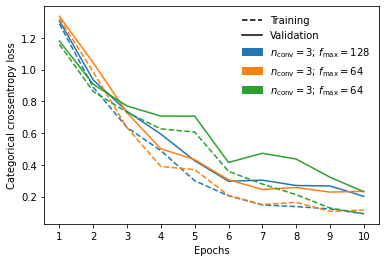

In [ ]:
df = pd.DataFrame(search_results).sort_values('best_val_cos', ascending=False)
display(df)



top_3_indices = df.index.values[:3]

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"$n_\\mathrm{{conv}}=${row_series['num_conv_layers']}; $f_\\mathrm{{max}}=${row_series['max_filters']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
# limit ticks to integers using the length of the last results loss curve
plt.xticks(x)
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)

## Testing Different Dense Layer combinations

In [ ]:
param_space = {
    'num_conv_layers': [3],
    'max_filters': [64,128],
    'dropout': [.3],
    'dense_nodes': [[64], [128], [512], [64, 128], [64, 512], [128, 512], [128, 64], [512, 128],[512, 64], [64, 128, 512],[512, 128, 64]]
}

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

search_results = []

# reuse from before:
for idx, params in enumerate(param_combis):
  
    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid', 
          activation='relu'
      ))
      filters /= 2
    
    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
    ]:
      model.add(layer)
    for nodes in params['dense_nodes']:
      model.add(Dense(nodes, activation='relu'))
      model.add(Dropout(params['dropout']))
    
    model.add(Dense(4, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['cosine_similarity']
    )

    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_cosine_similarity', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train, 
      y=y_train, 
      batch_size=64,
      # reduce number of epochs for speed reasons --> should be higher!
      epochs=10, 
      validation_data=(x_val, y_val), 
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_cosine_similarity'])
    best_val_cos      = np.max(fit_results.history['val_cosine_similarity'])
    best_val_cos_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_model = load_model(filepath)
    best_val_cos_train_loss, best_val_cos_train_cos = best_model.evaluate(x_train, y_train)

    # store results
    search_results.append({
        **params,
        'best_val_cos_train_cos': best_val_cos_train_cos,
        'best_val_cos': best_val_cos,
        'best_val_cos_train_loss': best_val_cos_train_loss,
        'best_val_cos_loss': best_val_cos_loss,
        'best_val_epoch': best_val_epoch,
         'history': fit_results.history
    })

We have a total of 22 combinations:
[{'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [64]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [128]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [512]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [64, 128]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [64, 512]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [128, 512]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [128, 64]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [512, 128]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [512, 64]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [64, 128, 512]}, {'num_conv_layers': 3, 'max_filters': 64, 'dropout': 0.3, 'dense_nodes': [512, 128, 128]}, {'num_conv_layers': 3, 'max_

,num_conv_layers,max_filters,dropout,dense_nodes,best_val_cos_train_cos,best_val_cos,best_val_cos_train_loss,best_val_cos_loss,best_val_epoch,history
7,3,64,0.3,"[512, 128]",0.992581,0.924373,0.040264,0.235650,7,"{'loss': [1.342706322669983, 0.837660074234008..."
13,3,128,0.3,[512],0.993915,0.918283,0.035947,0.235342,8,"{'loss': [3.3140552043914795, 1.14894390106201..."
1,3,64,0.3,[128],0.983734,0.899944,0.067729,0.290148,9,"{'loss': [1.4902669191360474, 1.13445687294006..."
11,3,128,0.3,[64],0.949103,0.895009,0.207224,0.358696,7,"{'loss': [1.7882909774780273, 1.27002215385437..."
15,3,128,0.3,"[64, 512]",0.958230,0.892183,0.148352,0.319229,9,"{'loss': [1.4283329248428345, 1.25874888896942..."
2,3,64,0.3,[512],0.974739,0.888147,0.114387,0.348770,9,"{'loss': [2.0730886459350586, 1.16302394866943..."
8,3,64,0.3,"[512, 64]",0.977743,0.883636,0.100615,0.351557,9,"{'loss': [2.1623387336730957, 1.21710085868835..."
5,3,64,0.3,"[128, 512]",0.947963,0.882556,0.157766,0.350197,9,"{'loss': [1.5655792951583862, 1.33486688137054..."
3,3,64,0.3,"[64, 128]",0.918979,0.867660,0.265256,0.412833,8,"{'loss': [1.4215924739837646, 1.24361300468444..."
17,3,128,0.3,"[128, 64]",0.885213,0.861919,0.367022,0.420012,6,"{'loss': [1.601110816001892, 1.333465218544006..."


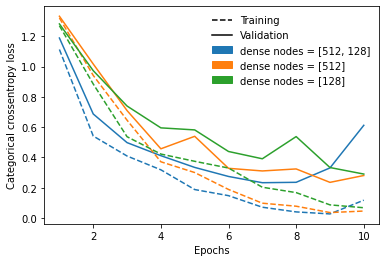

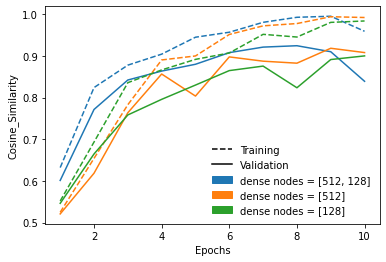

In [ ]:
# which combinations perform best?
df = pd.DataFrame(search_results).sort_values('best_val_cos', ascending=False)
display(df)

top_3_indices = df.index.values[:3]


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)
plt.show()

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_cosine_similarity'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}"
  plt.plot(x, row_series['history']['train_cosine_similarity'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_cosine_similarity'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Cosine_Similarity')

# people should use those frames less frequently I think
plt.legend(frameon=False)


## Adding l2 

In [ ]:
param_space = {
    'num_conv_layers': [3],
    'max_filters': [64],
    'dense_nodes': [[512,128]],
    'dropout': [.3],
    'l2': [1e-6, 1e-5, 1e-4, 1e-3]
}



value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

search_results = []

for idx, params in enumerate(param_combis):
  
    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(x_train[0].shape))

    filters = params['max_filters']
    for layer in range(params['num_conv_layers']):
      model.add(Conv2D(
          filters, kernel_size=2, padding='valid', 
          activation='relu', kernel_regularizer=l2(params['l2'])
      ))
      filters /= 2
    
    for layer in [
      MaxPooling2D(pool_size=2),
      Dropout(params['dropout']),
      Flatten(),
    ]:
      model.add(layer)
    for nodes in params['dense_nodes']:
      model.add(Dense(nodes, activation='relu', kernel_regularizer=l2(params['l2'])))
      model.add(Dropout(params['dropout']))
    
    model.add(Dense(4, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['cosine_similarity']
    )

    ########################################

    # we choose our best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"cnn_paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_cosine_similarity', verbose=0, save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=x_train, 
      y=y_train, 
      batch_size=64,
      # reduce number of epochs for speed reasons --> should be higher!
      epochs=10, 
      validation_data=(x_val, y_val), 
      callbacks=[checkpoint, HistoryEpoch((x_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_cosine_similarity'])
    best_val_cos      = np.max(fit_results.history['val_cosine_similarity'])
    best_val_cos_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    best_model = load_model(filepath)
    best_val_cos_train_loss, best_val_cos_train_cos = best_model.evaluate(x_train, y_train)

    # store results
    search_results.append({
        **params,
        'best_val_cos_train_cos': best_val_cos_train_cos,
        'best_val_cos': best_val_cos,
        'best_val_cos_train_loss': best_val_cos_train_loss,
        'best_val_cos_loss': best_val_cos_loss,
        'best_val_epoch': best_val_epoch,
         'history': fit_results.history
    })

We have a total of 4 combinations:
[{'num_conv_layers': 3, 'max_filters': 64, 'dense_nodes': [512, 128], 'dropout': 0.3, 'l2': 1e-06}, {'num_conv_layers': 3, 'max_filters': 64, 'dense_nodes': [512, 128], 'dropout': 0.3, 'l2': 1e-05}, {'num_conv_layers': 3, 'max_filters': 64, 'dense_nodes': [512, 128], 'dropout': 0.3, 'l2': 0.0001}, {'num_conv_layers': 3, 'max_filters': 64, 'dense_nodes': [512, 128], 'dropout': 0.3, 'l2': 0.001}]
Start run 1/4: Parameters: {'num_conv_layers': 3, 'max_filters': 64, 'dense_nodes': [512, 128], 'dropout': 0.3, 'l2': 1e-06}
17/17 [==============================] - 0s 15ms/step - loss: 0.3683 - cosine_similarity: 0.9004
Start run 2/4: Parameters: {'num_conv_layers': 3, 'max_filters': 64, 'dense_nodes': [512, 128], 'dropout': 0.3, 'l2': 1e-05}
17/17 [==============================] - 0s 15ms/step - loss: 0.0894 - cosine_similarity: 0.9910
Start run 3/4: Parameters: {'num_conv_layers': 3, 'max_filters': 64, 'dense_nodes': [512, 128], 'dropout': 0.3, 'l2': 0.000

,num_conv_layers,max_filters,dense_nodes,dropout,l2,best_val_cos_train_cos,best_val_cos,best_val_cos_train_loss,best_val_cos_loss,best_val_epoch,history
1,3,64,"[512, 128]",0.3,0.000010,0.990960,0.886533,0.089351,0.379172,8,"{'loss': [1.7677048444747925, 1.24312067031860..."
2,3,64,"[512, 128]",0.3,0.000100,0.936309,0.866384,0.338514,0.557916,7,"{'loss': [2.264085054397583, 1.431349396705627..."
0,3,64,"[512, 128]",0.3,0.000001,0.900357,0.858948,0.368309,0.467728,9,"{'loss': [3.4390828609466553, 1.37417125701904..."
3,3,64,"[512, 128]",0.3,0.001000,0.939823,0.847232,0.782661,0.999349,8,"{'loss': [3.265650510787964, 2.107659578323364..."


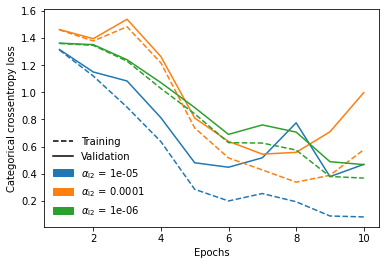

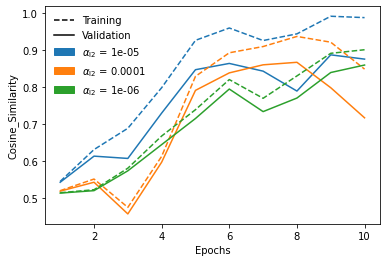

In [ ]:
# which combinations perform best?
df = pd.DataFrame(search_results).sort_values('best_val_cos', ascending=False)
display(df)

top_3_indices = df.index.values[:3]


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"$\\alpha_\\mathrm{{l2}}$ = {row_series['l2']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Categorical crossentropy loss')

# people should use those frames less frequently I think
plt.legend(frameon=False)
plt.show()

# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# let's have a look at loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_cosine_similarity'])+1)
  parameter_combination_string = f"$\\alpha_\\mathrm{{l2}}$ = {row_series['l2']}"
  plt.plot(x, row_series['history']['train_cosine_similarity'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_cosine_similarity'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.ylabel('Cosine_Similarity')

# people should use those frames less frequently I think
plt.legend(frameon=False)


param_space = {
    'num_conv_layers': [3],
    'max_filters': [64],
    'dense_nodes': [[512,128]],
    'dropout': [.3],
    'l2': [1e-6]
} seemed to perform best

# Training best architecture on full dataset

In [ ]:
param_space = {
    'num_conv_layers': [3],
    'max_filters': [64],
    'dense_nodes': [[512,128]],
    'dropout': [.3],
    'l2': [1e-6]
}

value_combis = itertools.product(*[v for v in param_space.values()])

# List comprehension short form:
param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]
for idx, params in enumerate(param_combis):
  model = Sequential()
  model.add(InputLayer(X_train[0].shape))

  filters = params['max_filters']
  for layer in range(params['num_conv_layers']):
    model.add(Conv2D(
    filters, kernel_size=2, padding='valid', 
    activation='relu', kernel_regularizer=l2(params['l2'])
    ))
    filters /= 2
    
  for layer in [
    MaxPooling2D(pool_size=2),
    Dropout(params['dropout']),
    Flatten(),
    ]:
    model.add(layer)
  for nodes in params['dense_nodes']:
    model.add(Dense(nodes, activation='relu', kernel_regularizer=l2(params['l2'])))
    model.add(Dropout(params['dropout']))
    
  model.add(Dense(4, activation='softmax'))

  model.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['cosine_similarity']
    )
  #filepath = f"Best_Model.hdf5"
  #checkpoint = ModelCheckpoint(filepath, monitor='val_cosine_similarity', verbose=0, save_best_only=True, mode='max')


  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 203, 203, 64)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 202, 202, 32)      8224      
                                                                 
 conv2d_2 (Conv2D)           (None, 201, 201, 16)      2064      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 16)      0         
                                                                 
 flatten (Flatten)           (None, 160000)            0         
                                                        

In [ ]:
hist = model.fit(
      x=X_train, 
      y=Y_train, 
      batch_size=128,
      # reduce number of epochs for speed reasons --> should be higher!
      epochs=100, 
      validation_data=(X_val, Y_val), 
      #callbacks=[checkpoint, HistoryEpoch((X_train, Y_train))],
      verbose=1
    )

Epoch 1/100
21/21 [==============================] - 28s 636ms/step - loss: 2.0779 - cosine_similarity: 0.5018 - val_loss: 0.8943 - val_cosine_similarity: 0.7131
Epoch 2/100
21/21 [==============================] - 10s 480ms/step - loss: 0.7749 - cosine_similarity: 0.7440 - val_loss: 0.5677 - val_cosine_similarity: 0.8176
Epoch 3/100
21/21 [==============================] - 10s 483ms/step - loss: 0.5124 - cosine_similarity: 0.8290 - val_loss: 0.3338 - val_cosine_similarity: 0.8955
Epoch 4/100
21/21 [==============================] - 10s 483ms/step - loss: 0.3373 - cosine_similarity: 0.8962 - val_loss: 0.2225 - val_cosine_similarity: 0.9322
Epoch 5/100
21/21 [==============================] - 10s 480ms/step - loss: 0.2730 - cosine_similarity: 0.9153 - val_loss: 0.2317 - val_cosine_similarity: 0.9304
Epoch 6/100
21/21 [==============================] - 10s 479ms/step - loss: 0.1826 - cosine_similarity: 0.9446 - val_loss: 0.2000 - val_cosine_similarity: 0.9426
Epoch 7/100
21/21 [=========

Test Loss: 0.3194798529148102
Test Accuracy: 0.9541124105453491
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91       236
           1       0.94      0.96      0.95       277
           2       0.99      1.00      0.99       200
           3       0.99      0.93      0.95       215

    accuracy                           0.95       928
   macro avg       0.95      0.95      0.95       928
weighted avg       0.95      0.95      0.95       928



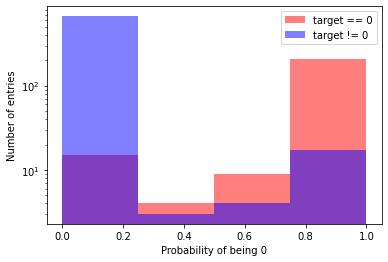

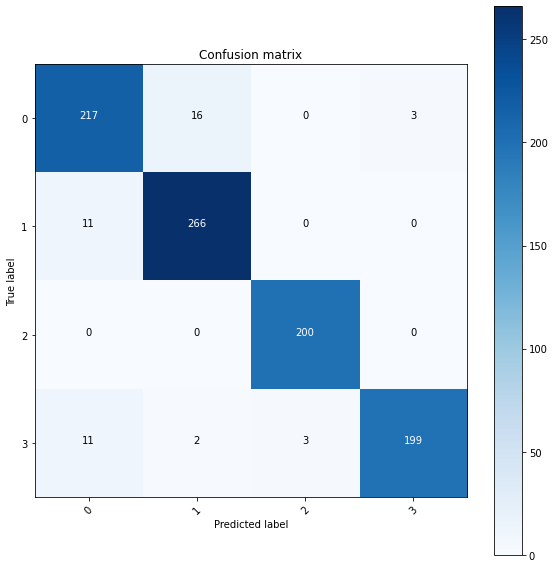

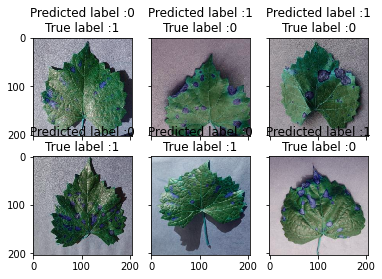

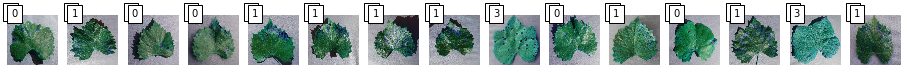

In [ ]:
evaluate(X_test, Y_test)

In [ ]:
def plot_history_cos(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Cosine Similarity')
    plt.plot(network_history.history['cosine_similarity'])
    plt.plot(network_history.history['val_cosine_similarity'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


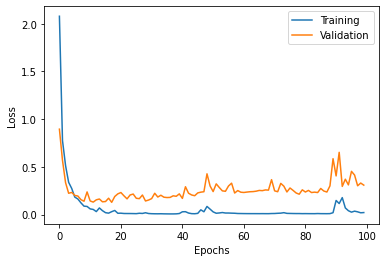

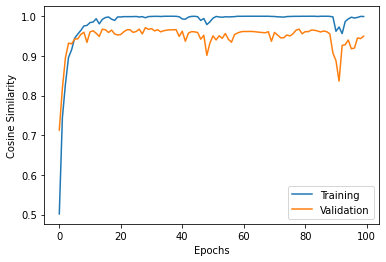

In [ ]:
plot_history_cos(hist)

In [ ]:
model.save('Final_Model')

INFO:tensorflow:Assets written to: Final_Model/assets


# Deploying grad cam

In [ ]:
model = load_model('Final_Model')

NameError: ignored

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)


## Balck Rot

In [ ]:
image_path = '/tmp/grape_disease/Black_rot/Black_rot (33).JPG'
image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (204, 204))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
preds = model.predict(image) 
i = np.argmax(preds[0])

In [ ]:
icam = GradCAM(model, i, 'conv2d_2') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (204, 204))


image= cv2.imread( image_path)
image = cv2.resize(image, (204, 204))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(204, 204) (204, 204, 3)


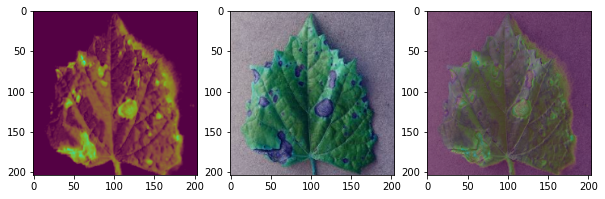

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

## Esca

(204, 204) (204, 204, 3)


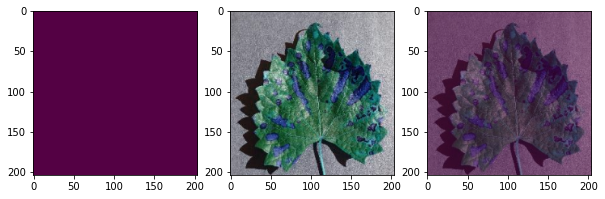

In [ ]:
image_path = "/tmp/grape_disease/Esca/Esca (1366).JPG"
image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (204, 204))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
preds = model.predict(image) 
i = np.argmax(preds[0])

icam = GradCAM(model, i, 'conv2d_2') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (204, 204))


image= cv2.imread(image_path)
image = cv2.resize(image, (204, 204))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

## Healthy

(204, 204) (204, 204, 3)


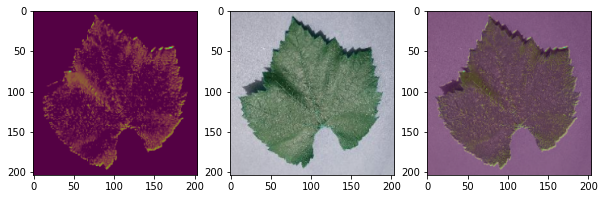

In [ ]:
image_path = "/tmp/grape_disease/Healthy/Healthy (119).JPG"
image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (204, 204))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
preds = model.predict(image) 
i = np.argmax(preds[0])

icam = GradCAM(model, i, 'conv2d_2') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (204, 204))


image= cv2.imread( image_path)
image = cv2.resize(image, (204, 204))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

## Leaf Blight

(204, 204) (204, 204, 3)


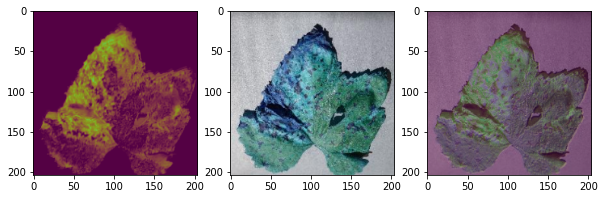

In [ ]:
image_path = "/tmp/grape_disease/Leaf_blight/Leaf_blight (10).JPG"
image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (204, 204))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
preds = model.predict(image) 
i = np.argmax(preds[0])

icam = GradCAM(model, i, 'conv2d_2') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (204, 204))


image= cv2.imread( image_path)
image = cv2.resize(image, (204, 204))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)